
The objective of this file is to generate a list of timestamps for when a passenger
should initiate a trip between floors. 
This file generates a list of passengers, and their trips.
Additionally an array of tuples containing a timestamp in seconds 
from 6AM to around 7PM as well as a passenger id will generated
this indicates that the passenger should initiate a trip.

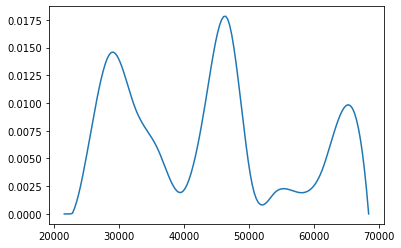

In [23]:
from passenger import *
import numpy as np
from scipy import interpolate
from scipy import integrate
import matplotlib.pyplot as plt
import random


# // -------- Simulation Constants --------

simulation_params = {
    'floors': 50,
    'elevators': 10, 
    'loading_time': 6, # seconds
    'offloading_time': 6, # seconds
    'time_per_floor': 4, # seconds
    'floor_height': 4, # metres
    'dt': 1, # seconds simulation step interval
    'passengers': 1500,

}

hours = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
val =   np.array([0, 30, 75, 50, 30, 10, 50, 90, 15, 10, 10, 20, 50, 0])


h2s = 60 * 60

seconds = hours * 60 * 60
seconds_int = np.linspace(6 * h2s, 19 * h2s, num = 150, endpoint=True)
tk = interpolate.splrep(seconds, val)
val_int = interpolate.splev(seconds_int, tk)
val_int = val_int.clip(min=0)

start = np.min(seconds_int)
end = np.max(seconds_int)

simulation_params['start'] = start
simulation_params['end'] = end

norm_int = val_int / np.sum(val_int)

cum_int = np.cumsum(norm_int) 

plt.plot(seconds_int, norm_int)


The function below generates Passengers as well as the trips that they will make

*Assumptions*:
- Weights are normaly distributed mean: 65kg and standard deviation of 30kg (assuming luggage)
- passengers always start and end at floor 0.
- Passengers can make up to 7 trips in a day and at least 2 (one up and down)


In [24]:

def generatePassengers(n, sp):
    
    weights = np.clip(np.random.normal(65, 30, n), 10, 170)
    trips = np.random.randint(3, 8, n)
    
    select = np.random.randint(0, sp['floors'], np.sum(trips - 2))
    select_index = 0

    out = []

    tripOwner = []

    for i in range(n):
        route = [0] * trips[i]

        tripOwner.extend([i] * (trips[i]-1))

        for y in range (1, trips[i]-1):
            route[y] = select[select_index]
            select_index = select_index + 1

            while(route[y] == route[y-1]):
                route[y] = np.random.randint(1, sp['floors'] - 1, 1)[0]

        # check last route is not 0
        while(route[trips[i]-2] == route[trips[i]-1]):
            route[trips[i]-2] = np.random.randint(1, sp['floors'] - 1, 1)[0]


        out.append(Passenger(weights[i], route))

    return {
        'passengers': out,
        'total_trips': sum(trips) - n,
        'trip_owner': tripOwner
    }


In [25]:
# Assume the building of 10 floors has 200 people

passengers = generatePassengers(simulation_params['passengers'], simulation_params)

print(passengers['total_trips'], len(passengers['trip_owner']))

5924 5924


In [26]:

shuffled_trips = list(passengers['trip_owner']); random.shuffle(shuffled_trips)

shuffled_trips[:20]


[1158,
 1141,
 738,
 453,
 1378,
 934,
 326,
 1069,
 1138,
 1251,
 454,
 1297,
 729,
 1028,
 721,
 656,
 1392,
 77,
 438,
 76]

[22923, 23127, 23192, 23199, 23233, 23261, 23517, 23542, 23544, 23597, 23616, 23631, 23695, 23715, 23767, 23772, 23778, 23805, 23841, 23850, 23850, 23876, 23907, 23923, 23947, 23969, 23974, 23974, 23977, 23981, 23990, 23995, 24041, 24049, 24088, 24097, 24124, 24135, 24153, 24194, 24197, 24205, 24207, 24214, 24221, 24232, 24244, 24245, 24273, 24329]
minute grouping: 3.9


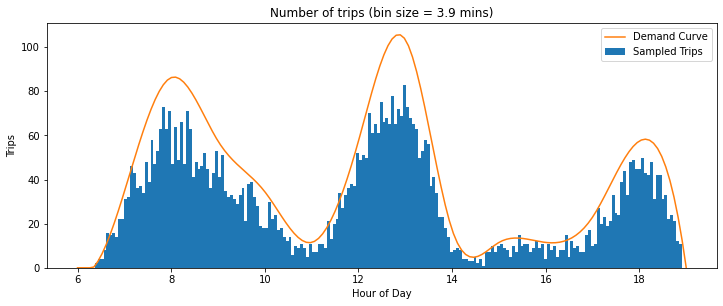

In [41]:
# sample timestamps for each trip

times = [round(np.interp(random.random(), cum_int, seconds_int)) for x in range(passengers['total_trips'])]

# times = times.sort()

times_scale = [x/(60*60) for x in times]

times.sort()
print(times[:50])

bins = 200

min_groups = ((end - start) / bins) / 60


print('minute grouping:', min_groups)


f = plt.figure()
f.set_figwidth(8*1.5)
f.set_figheight(3*1.5)

plt.hist(times_scale, bins)

plt.plot(seconds_int / (60*60), norm_int * passengers['total_trips'])
plt.title('Number of trips (bin size = '+ str(min_groups) + ' mins)')
plt.xlabel('Hour of Day')
plt.ylabel('Trips')

plt.legend(['Demand Curve','Sampled Trips'])


import io
import base64

iobytes = io.BytesIO()
plt.savefig(iobytes, format='jpg')
iobytes.seek(0)
distPlot = base64.b64encode(iobytes.read())



In [43]:
# export data:

import pickle

db = dict({
    'passengers': passengers['passengers'], 
    'traffic_times': times, 
    'traffic_passengers': shuffled_trips,
    'simulation_params': simulation_params,
    'distribution': str(distPlot),
})


filename = "p{}e{}f{}.bin".format(simulation_params['passengers'],simulation_params['elevators'], simulation_params['floors'])

# with open(filename, 'wb') as f:
#     pickle.dump(db, f)


def secondstotime(sec):
    hours = int(sec / (60*60))
    remainder = sec - (60*60*hours)
    mins = int(remainder / 60)
    remainder = round(sec - (60*mins))
    return '{:02d}:{:02d}:{:02d}'.format(hours, mins, remainder)

print('len', len(shuffled_trips), len(times))

for index, passenger in enumerate(passengers['passengers'][:10]):
    indices = [i for i, passenger_id in enumerate(shuffled_trips) if passenger_id == index]
    timestamps = [times[trip_id] for trip_id in indices]
    print(round(passenger.weight), passenger.route, timestamps)


len 5924 5924
73 [0, 13, 42, 22, 0] [28674, 45412, 47837, 61426]
78 [0, 13, 0] [42597, 67100]
33 [0, 17, 30, 49, 25, 0] [29159, 29234, 44022, 45640, 46483]
56 [0, 10, 12, 23, 0] [37510, 46558, 65639, 65846]
56 [0, 9, 17, 19, 0] [31304, 45091, 48241, 61780]
118 [0, 7, 0] [41693, 47079]
44 [0, 26, 0] [39718, 65065]
82 [0, 19, 2, 38, 21, 0] [43499, 44012, 44747, 63889, 66968]
67 [0, 40, 1, 20, 42, 0] [29485, 33676, 36755, 65403, 66326]
37 [0, 42, 48, 5, 22, 0] [40164, 47589, 49173, 53626, 63834]
